#Finding hosts receiving fraudulent traffic
Author: Alexey Khuraskin <askhuraskin@gmail.com>

In this document I describe my approach for detecting fraudulent traffic. I make the assumption that the reader has read the assignmnent and is familiar with dataset specification.

## Introduction
Let's assume that the task is to rank web sites by the share of fraudulent traffic they receive. We can think of the traffic in terms of the number of unique clients or their requests to the web site.

The definition of fraudulent traffic is not very clear so we have to define it first. In the setup of pay-per-view networks, where ad views matter, the advertiser buys a user's attention and pays intermediary or publisher per view. The advertiser's expectations are met only if the user has seen the impression, but a dishonest publisher or intermediary could use artificial traffic generation to increase their revenue. Having an impression-level unlabeled dataset, we will find traffic that is most likely to be generated without having attracted the user's attention.

The sources of such traffic could be:
1. Botnets -- fully automated distributed systems simulating human behaviour.
2. Adware -- malicious software that works on an infected computer and acts in fraudster's interests, whether simultaneously with user's activity or not.
3. People hired to view advertisement.

There are several possible approaches to this problem:
1. Look for the traffic patterns of every web site and identify suspicious parts of it. Possible sources of irregularities:
    1. Temporal patterns. It may be the case that fraudulent traffic occurs in bursts. It also may not be the case if fraudsters use malicious software on victims' computers which visits targeted sites in the background simultaneously with the victims' web activity. If so, temporal cycles of the attacked sites would look normal. We have only one day of data, so it is hard to find temporal patterns in the traffic.
    2. Geographical patterns. IP addresses that we have are obfuscated using the unknown algorithm so we don't have access to this sort of information.
2. Analyze the characteristics of every client, identify those behaving badly and rank hosts by the share of bad traffic. How to define "bad traffic" mean? There are a few options:
    1. Build a model for organic traffic and identify clients that look like strong outliers for this model. This approach has some drawbacks:
        1. It is hard to implement it having only one day of history. From basic intuition, temporal features, such as request intensity according to diurnal cycle, should have high weight in the model describing bahavior of human beings. We cannot consistently extract this information from the data we have.
        2. Advertising campaign may have been targeted to non-normal users. In this case, the advertiser would not like to blame theses users and exclude them from the campaign.
        3. Our dataset is unlabeled, so it would be difficult to validate our model. In the case of significant share of fraudulent traffic the model could be skewed towards it so we could classify it as an organic one.
    2. Quantify characteristics of all clients and clusterize them. Then mark one of the clusters of clients as a fraudulent one. The main drawback is that it is very likely that clients would be described by high-dimensional vectors which would make visualisation, evaluation and inference difficult.
    3. Considering the subset of {IP x URL} views as a bipartite graph, make a weighted projection on one of the partitions and detect communities in it. Among these communities, find the communities consisting mostly of suspicious clients or web sites. This approach ignores all technical information except for browsing history. Drawbacks:
        1. It is hard to evaluate its performance.
        2. Technical information may be valuable and it is not reasonable to discard it.
    4. Derive static rules using domain knowledge to identify fraudulent clients and use this set as a part of the labeled data to train a classifier. Use this classifier to detect more fraudulent clients. This method will be described in this report.
        
## Brief algorithm description
The process consists of the following steps:

1. Feature generation
    1. Read dataset, preprocess raw data to extract view-level features
    2. Generate per-IP statistics and prepare feature table for clients
2. Find set suspicious clients that are definitely fraudulent
3. Using these users as "benchmark" users find clients that have similar browsing history

## Algorithm
Detailed explanation with python code is below. This code uses python-2.7. All package prerequisites could be installed using pip: matplotlib, numpy, pandas, seaborn, tldextract, user-agents, gensim.

### Load data and extract per-view features
If you would like to run the code listed below please set working_dir variable name pointing to the directory with the input dataset.

The following feature cleaning/trasformations happen below:
1. User agent string is parsed using ([user-agents](https://pypi.python.org/pypi/user-agents)) library. Browser info provided in the dataset is replaced by the extracted one because user-agents identifies it more reliably. Original user agent string is replaced by the more compact one provided by the library.
2. URLs are normalized as well. We use only registered_domain part of the top-level domain.
3. Window size is replaced by two features:
    1. Geometric mean of a window dimensions sqrt(width * height).
    2. Whether bottom right corner of the browser window was in view or not. Using information that we have, we can only check if the right corner was in the bottom-right quadrant because screen resolution is not given.
4. We add 's' column equal to 1 to make statistics calculation easier.

In [1]:
%matplotlib inline
import os
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import numpy as np
import pandas as pd
import math

pylab.rcParams['figure.figsize'] = 14,8
pd.set_option('max_colwidth', 20)
pd.set_option('display.width', 1000)
pd.set_option('display.precision', 3)

working_dir = '/home/ask/devel/integral/data'

fraud_hosts = 'featureplay.com,uvidi.com,spryliving.com,greatboxgames.com,mmabay.co.uk,workingmothertv.com,' \
              'besthorrorgame.com,dailyparent.com,superior-movies.com,yourhousedesign.com,outdoorlife.tv,drumclub.info,' \
              'cycleworld.tv,hmnp.us,nlinevideos.com'.split(',')
def is_fraud_host(s):
    any(map(lambda x: s.endswith(x), fraud_hosts))

from urlparse import urlparse
import tldextract
def clean_urls(d):
    d.url = d.url.apply(lambda x: tldextract.extract(urlparse(x).netloc).registered_domain)

import user_agents
def process_ua_string(s):
    ua = user_agents.parse(s)
    return pd.Series({'br_family':ua.browser.family, 'ua':str(ua)})

def window_features(s):
    if s is np.nan:
        return pd.Series({'wsize': np.nan, 'visible': np.nan})
    x, y, w, h = map(int, s)
    return pd.Series({'wsize': math.sqrt(math.fabs((w+x)*(h+y))), 'visible': int((x+w) > 0 and (y+h)>0) })

    
f = os.path.join(working_dir, 'input', 'Integral_data_set.tsv')
d = pd.read_csv(f, sep='\t', names='time,ip,br_type,useragent,url,inview,plugins,window,latency'.split(','), parse_dates=['time'], index_col=[0])
d['s'] = pd.Series(1, index=d.index)

clean_urls(d)
%time d = pd.concat([d, d.window.str.strip('()').str.split(',').apply(window_features)], axis=1)
d.drop('window', axis=1, inplace=True)
print 'Window size  processed'
%time d = pd.concat([d, d.useragent.apply(process_ua_string)], axis=1)
d.drop('br_type', axis=1, inplace=True)
d.drop('useragent', axis=1, inplace=True)
print 'User Agent string processed'
print 'Dataset columns: [%s]' % ', '.join(d.columns)

CPU times: user 1min 2s, sys: 1.04 s, total: 1min 3s
Wall time: 1min 2s
Window size  processed
CPU times: user 3min 35s, sys: 2.59 s, total: 3min 37s
Wall time: 3min 36s
User Agent string processed
Dataset columns: [ip, url, inview, plugins, latency, s, visible, wsize, br_family, ua]


### Generate client-level statistics
Prepare features aggregated by every client IP address:
1. Mean of the given variable whether impression was in view or not.
2. Group of features derived from the number of requests:
    1. total number of impressions requested,
    2. per-minute and per-hour features: max, min, mean of non-zero values of requests per minute (hour).
3. Number of unique browser families reported to be used.
4. Number of unique normalized user agent strings.
5. Number of unique normalized URLs accessed.
6. Mean latency.
7. Standard deviation of the latency.
8. Number of unique plugins.
9. Mean of the features derived from the browser window size characteristics: share of visible bottom-right corner and average window size.
10. req_h_v: the measure of variation of requests intensity over the day.
11. ua_plg = ua_u/plg_u, number of unique UA strings divided by the number of unique plugins number. High value may be considered as an indicator of frequent obfuscation of UA string, which is simpler to change compared to the number of plugins. Nevertheless, we do not know how reliable plugins number identification is.

In [2]:
g = d.groupby('ip')
dip = pd.DataFrame({  'inview_m' : g.inview.mean()
                    
                    , 'req_c' : g.s.count()
                    , 'req_m_max' : d.s.groupby([d.ip, d.index.hour*60+d.index.minute]).sum().reset_index()[['ip', 's']].groupby('ip').max().s
                    , 'req_h_max' : d.groupby([d.ip, d.index.hour]).sum().reset_index()[['ip', 's']].groupby('ip').max().s
                    , 'req_m_min' : d.groupby([d.ip, d.index.hour*60+d.index.minute]).sum().reset_index()[['ip', 's']].groupby('ip').min().s
                    , 'req_h_min' : d.groupby([d.ip, d.index.hour]).sum().reset_index()[['ip', 's']].groupby('ip').min().s
                    , 'req_m_m' : d.groupby([d.ip, d.index.hour*60+d.index.minute]).sum().reset_index()[['ip', 's']].groupby('ip').mean().s
                    , 'req_h_m' : d.groupby([d.ip, d.index.hour]).sum().reset_index()[['ip', 's']].groupby('ip').mean().s
                    
                    , 'br_f_u' : g.br_family.nunique()
                    , 'ua_u' : g.ua.nunique()
                    , 'urls_u' : g.url.nunique()
                    , 'lat_m' : g.latency.mean()
                    , 'lat_s' : g.latency.std().fillna(0)
                    , 'plg_u' : g.plugins.nunique()
                    , 'vis_m' : g.visible.mean()
                    , 'wsz_m' : g.wsize.mean()
                })
dip['req_h_v'] = (dip.req_h_max - dip.req_h_min)/dip.req_h_max
dip['ua_plg'] = dip.ua_u/dip.plg_u

Some columns, the technical ones, provide significant amount of missing values:

In [3]:
dip.isnull().sum()

br_f_u          0
inview_m      347
lat_m         421
lat_s           0
plg_u           0
req_c           0
req_h_m         0
req_h_max       0
req_h_min       0
req_m_m         0
req_m_max       0
req_m_min       0
ua_u            0
urls_u          0
vis_m        1925
wsz_m        1925
req_h_v         0
ua_plg          0
dtype: int64

Spearman and Pearson (rank) correlation matrices of the generated features differ significantly which means that we have to transform the data in order to capture linear dependencies here.

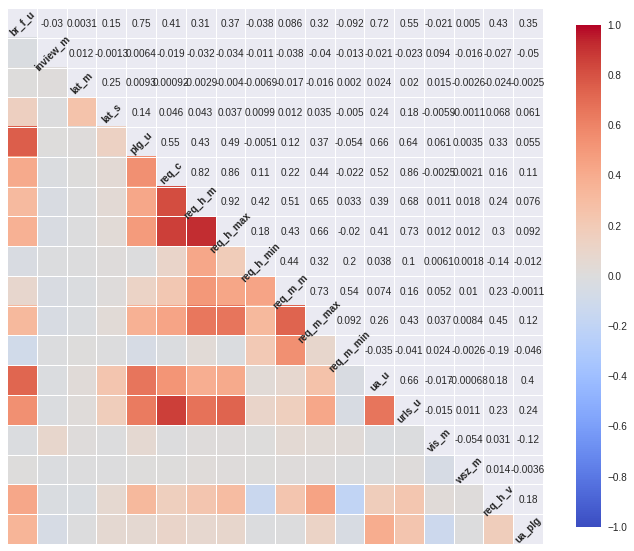

In [4]:
pylab.rcParams['figure.figsize'] = 12,12
sns.corrplot(dip, method='pearson')

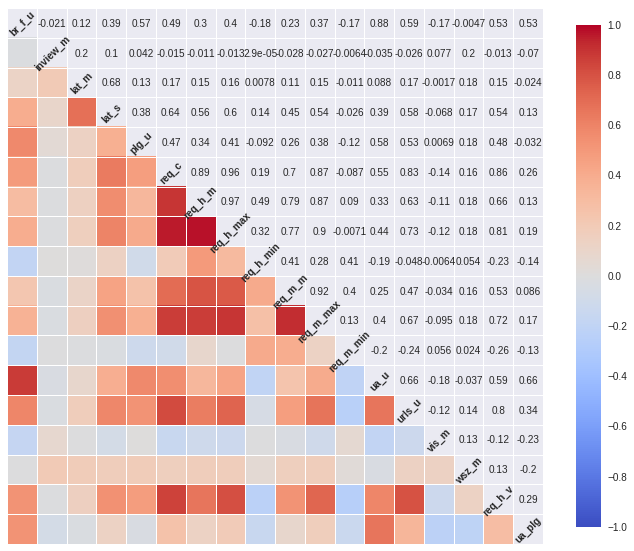

In [5]:
pylab.rcParams['figure.figsize'] = 12,12
sns.corrplot(dip, method='spearman')

### Find fraudulent users using static rules
We can identify users that behave suspiciously. I did not make the rules list exhaustive to eliminate false positive errors. First, let's look at the share of impressions with invisible bottom-right corner. There is a distinct set of clients hiding impressions. We will assume that they are fraudulent.

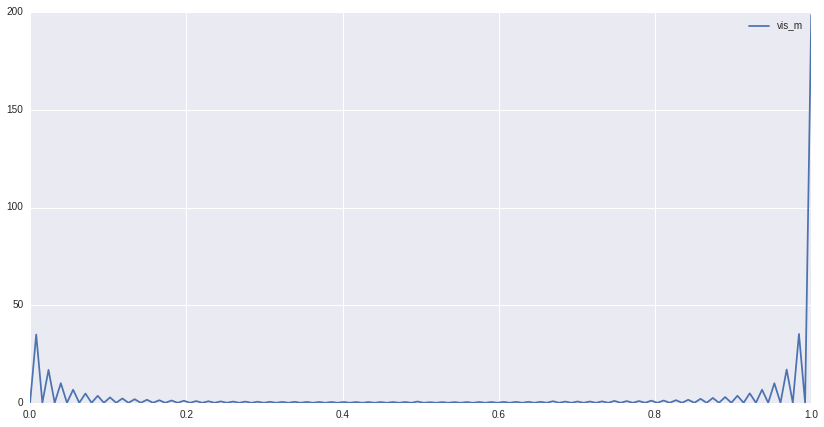

In [6]:
pylab.rcParams['figure.figsize'] = 14,7
sns.kdeplot(dip.vis_m)

We also observe a portion of clients that keep the size of the window to be small. We blame them as well.

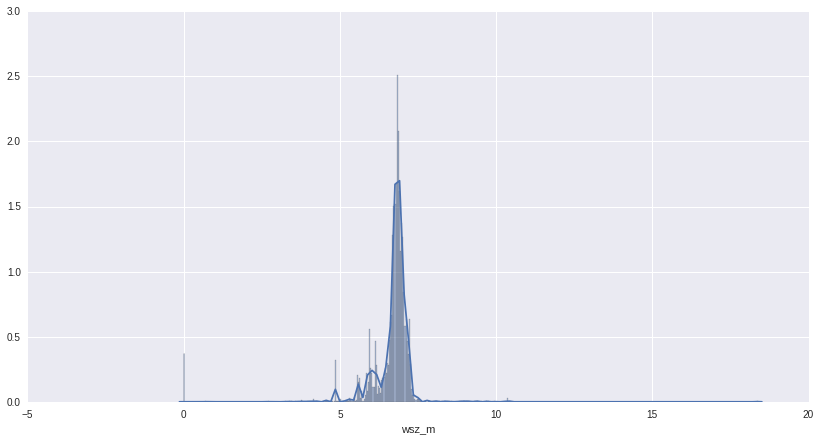

In [7]:
pylab.rcParams['figure.figsize'] = 14,7
sns.distplot(dip.wsz_m[~dip.wsz_m.isnull()].apply(lambda x: math.log(1+x)))

The same story is seen with the inview_m feature derived from the field provided in the dataset:

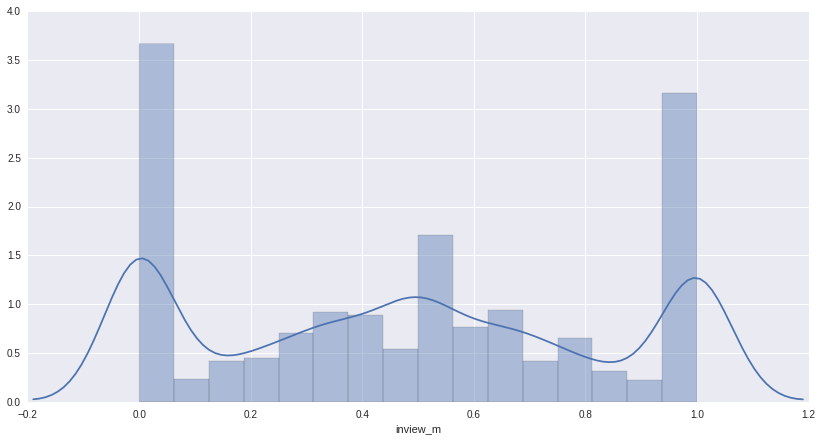

In [8]:
pylab.rcParams['figure.figsize'] = 14,7
sns.distplot(dip.inview_m[~dip.inview_m.isnull()])

Using these considerations, we mark blamed clients as 'bad' and calculate some statistics. We act conservatively and do not include 0 value into decision interval for inview_m allowing the possibility for impression analysis mechanism to always produce false negatives (we don't know how it works).

In [9]:
def filter_bad(r):
    return int((0 <= r.vis_m < 0.2)
               or (r.wsz_m>=0 and math.log(1+r.wsz_m) <= 3)
               or (0 < r.inview_m<0.2))
dip['bad'] = dip.apply(filter_bad, axis=1)
print 'Number of blamed clients: %s, which is %s of all clients' % (dip.bad.sum(), 1.*dip.bad.sum()/dip.shape[0])
print 'Share of traffic generated by blamed clients: %s' % d.ip.isin(dip[dip.bad > 0].index).mean()

Number of blamed clients: 478, which is 0.0581791626095 of all clients
Share of traffic generated by blamed clients: 0.110794910734


At this point, we have a way to label our dataset. We can assign 'fraud' label to the request or to the client having 11% or 5.7% share of response variable equal to 1. We are going to identify other users not captured by our static rules.

We could try to employ various classifiers to this problem. Nevertheless, our sample has the properties preventing us from doing this:
1. Imbalanced dataset. We can use upsampling, nevertheless.
2. A lot of missing values. We'll have to impute if our method cannot handle them.
3. A lot of outliers.

Conditions 2-3 make our setup too unstable for SVM, logistic regression, and neural nets. We might want to employ tree-based methods, but they would not work by construction of our training set. K-nearest neighbor classifiers will also work well in the presence of outliers but not in the presence of missing values. In addition, KNN classifiers are hard to control. Trees are good in conditions 2-3, but they will perfectly fit splitting rules built into filter_bad() method and will add no additional predictive power.

### Looking for the clients similar to the fraudulent ones using their browsing history
This section is written in the assumption that fraudsters have a limited number of available outbound IP addresses so they have to reuse them. In this situation, browsing history of the clients from the same "fraudnet" will be similar.

We can represent browsing history as a sparse [client x URL] matrix with non-zero elements representing the number of times the user visited the website. We can reduce dimensionality of this matrix by using PCA to the TF-IDF normalized matrix. Here we consider the matrix as a corpus of documents, each line represents a bag-of-word document with a number of word occurences in the document.

We can train our favorite classifier such as logit, SVM or GBM on the upsampled training sample to estimate probability of fraud for every client. I believe it may work well in our conditions. Nevertheless, below I describe a slightly different approach. Instead of PCA we will use Latent Dirichlet Allocation to reduce dimensionality and after that check cosine similarity of a client under examination with the clients we identified as fraudulent.

Imports, logging, helpers:

In [10]:
from abc import ABCMeta, abstractmethod
import csv
import logging
import os
import errno
import tempfile
from gensim import corpora, models, similarities
import numpy as np
import pandas as pd

FORMAT = '%(asctime)-15s %(levelname)s\t%(filename)s:%(lineno)d\t%(funcName)s %(message)s'
logging.basicConfig(format=FORMAT, level=logging.INFO)

def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise


def chunk(iterable, chunk_size):
    """Generate sequences of `chunk_size` elements from `iterable`."""
    iterable = iter(iterable)
    while True:
        cur_chunk = []
        try:
            for _ in range(chunk_size):
                cur_chunk.append(iterable.next())
            yield cur_chunk
        except StopIteration:
            if cur_chunk:
                yield cur_chunk
            break

Abstract model that implements methods to parse browsing history in the TSV format with fields

    [ip, url, count([ip, url])]

In [11]:
class Model(object):
    __metaclass__ = ABCMeta

    def __init__(self, input_filename):
        self.input_filename = input_filename

    @abstractmethod
    def create_model(self):
        pass

    def load_visits_from_file(self, filename):
        with open(filename, 'r') as tsvfile:
            for x in self.load_visits(tsvfile):
                yield x

    @staticmethod
    def load_visits(tsvfile):
        reader = csv.reader(tsvfile, delimiter='\t')
        cur_ip = None
        history = []
        for row in reader:
            ip, url, visits = row[0], row[1], int(row[2])
            if ip != cur_ip:
                if cur_ip:
                    yield (cur_ip, history)
                cur_ip = ip
                history = []
            history += [url] * visits
        yield (cur_ip, history)

LDA model ([wiki](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation)) gets browsing history for every client and considers it as a 'document'. It transforms sparse vector of URLs visited by every client into a denser representation with maximum 30 non-zero components. This vector represents a mixture of unobserved, or latent, 'topics' that generate client's browsing history that we observe.

In [12]:
class LdaModel(Model):
    def __init__(self, lda_filename):
        super(LdaModel, self).__init__(lda_filename)
        self.lda_filename = lda_filename

        self.dictionary = None
        self.model = None
        self.create_model()

    def create_model(self):
        logging.debug('Building LDA model from scratch, filename %s' % self.lda_filename)
        self.dictionary = corpora.Dictionary((doc[1] for doc in self.load_visits_from_file(self.lda_filename)))
        self.dictionary.filter_extremes(no_below=1, no_above=0.5)

        bow_corpus = [self.dictionary.doc2bow(doc[1]) for doc in self.load_visits_from_file(self.lda_filename)]
        self.model = models.LdaMulticore(bow_corpus, id2word=self.dictionary, num_topics=30, passes=10, workers=2)
        logging.info('LDA model trained')
        return self

Similarity index stores the set of LDA-transformed clients' visiting history. It calculates cosine similarities ([wiki](https://en.wikipedia.org/wiki/Cosine_similarity)) with every client from the index for a given LDA-transformed  client's browsing history. After that, it takes average of the top 50 calculated similarities.

In [13]:
class SimilarityIndex(Model):
    def __init__(self, lda_model, crooks_filename):
        super(SimilarityIndex, self).__init__(input_filename=crooks_filename)
        self.lda_model = lda_model
        self.crooks_filename = crooks_filename

        self.dictionary = lda_model.dictionary
        self.model = lda_model.model
        self.index = None
        logging.debug('Create similarity index for %s' % os.path.basename(self.crooks_filename))
        self.create_model()

    def create_model(self):
        bow_corpus = [self.dictionary.doc2bow(doc[1]) for doc in self.load_visits_from_file(self.crooks_filename)]
        self.index = similarities.MatrixSimilarity(self.model[bow_corpus], num_features=self.model.num_topics)

        logging.info('Similarity index for %s created' % self.crooks_filename)
        return self

    def calculate_similarities(self, items, n_best=50):
        return np.transpose(np.vstack((np.array([item[0] for item in items]),
                                       np.mean(
                                           np.partition(self.index[self.model[
                                               [self.dictionary.doc2bow(item[1]) for item in items]]],
                                                        -n_best, axis=1)[:, -n_best:],
                                           axis=1)
                                       )))

    def visits_to_similarities(self, fin, fout):
        chunk_size = 500
        for i, docs_chunk in enumerate(chunk(self.load_visits(fin), chunk_size)):
            processed = self.process_chunk(docs_chunk)
            fout.writelines([processed, '\n'])
            fout.flush()
            logging.info('Chunk %s' % i)
        logging.info('Finished')

    def process_chunk(self, docs_chunk):
        return '\n'.join(map(lambda cols: '\t'.join(cols), self.calculate_similarities(docs_chunk).tolist()))

Function rank_suspicious_clients() utilizes classes described above. It ranks clients, who we have information about, by their similarities to the clients who are surely fraudulent according to our static rule.

In [14]:
def rank_suspicious_clients(visits_file, crooks_file, suspects_file, suspects_file_out):
    lda_model = LdaModel(visits_file)
    crooks_index = SimilarityIndex(lda_model=lda_model, crooks_filename=crooks_file)

    with open(suspects_file, 'r') as fin, tempfile.NamedTemporaryFile() as fout:
        crooks_index.visits_to_similarities(fin, fout)
        pd.read_csv(fout.name, sep='\t', names='ip,suspiciousness'.split(',')).sort('suspiciousness', ascending=False). \
            to_csv(suspects_file_out, sep='\t', index=False, header=True)

Identify bad clients and traffic that was generated by them. We assume that all traffic going from bad clients is fraudulent.

In [15]:
bad_clients = dip[dip.bad > 0].index
bad_traffic = d[d.ip.isin(bad_clients)]
print 'Number of bad clients: %s' % bad_clients.shape[0]

Number of bad clients: 478


Find clients similar in terms of cosine similarity to the clients that we already identified as fraudulent. We exclude clients with less than 4 requests because we do not have enough information about them.

In [16]:
def save_visits(d, fout):
    """Save visits information for every ip from the given dataset"""
    d.reset_index()[['ip', 'url', 's']].groupby(['ip', 'url']).sum().reset_index().to_csv(fout, sep='\t', index=False, header=False)

bad_traffic_data = os.path.join(working_dir, 'bad_traffic.tsv')
all_traffic_data = os.path.join(working_dir, 'all_traffic.tsv')
suspects_data = os.path.join(working_dir, 'suspects.tsv')
suspects_ranked = os.path.join(working_dir, 'suspects_ranked.tsv')
save_visits(bad_traffic, bad_traffic_data)

almost_all_clients = dip.query('req_c > 3').index
# almost_all_clients = dip.query('req_c > 5 and urls_u > 1').index
save_visits(d[d.ip.isin(almost_all_clients)], all_traffic_data)
save_visits(d[d.ip.isin(almost_all_clients)], suspects_data)

rank_suspicious_clients(visits_file=all_traffic_data, crooks_file=bad_traffic_data,
                        suspects_file=suspects_data, suspects_file_out=suspects_ranked)

Plot similaritires distribution:

In [17]:
pd.read_csv(suspects_ranked, sep='\t').plot()

We observe a distinct stump on the graph above on the client number 131 which means that browsing histories of the clients above this point are similar to the bad clients that we have already selected. Let's update our bad clients set by these IP addresses:

In [18]:
bad_clients_static = bad_clients.copy()
bad_clients = bad_clients_static | set(pd.read_csv(suspects_ranked, sep='\t').ip[:131])
print 'Bad clients number: %s' % len(bad_clients)

Bad clients number: 590


### Find hosts with significant share of fraudulent traffic
Top 30 hosts ordered by the share of suspicious traffic they receive:

In [19]:
d['bad'] = d.ip.isin(bad_clients).astype(int)
g = d.groupby('url')
df = pd.DataFrame({
        'numreq':g.s.sum()
        , 'bad_share' : g.bad.mean()
    })
df[df.numreq > 50].sort('bad_share', ascending=False)[:30]

bad_share  numreq
url                                    
hmnp.us                    1.00      58
dieng.in                   1.00     163
comodo.com                 1.00      74
programacioniii.tk         1.00     199
lovepanky.com              1.00      58
handonreviews.net          1.00      82
mangapark.com              1.00     105
drumclub.info              1.00      59
narutoget.com              0.99    1092
dbz.tv                     0.97     124
dallasnews.com             0.96     326
realclearpolitics...       0.96     346
bada.tv                    0.93      60
recipe4living.com          0.93     351
animeget.com               0.92    1622
shoppinglifestyle...       0.90      60
insuranceshack.com         0.87      54
ap.org                     0.83     157
dailypress.com             0.82      57
brandzones.com             0.82      51
247gamer.net               0.80     437
wildtangent.co.uk          0.76      70
morningstar.com            0.74     154
startribune.com            0.72    1202
wealthinvestor.co...       0.71      56
lookmoms.com               0.69      65
addictinggames.com         0.69     226
onegreenplanet.org         0.63     274
chron.com                  0.58     359
supercheats.com            0.53      79

Plot of the share of suspicious traffic for all hosts:

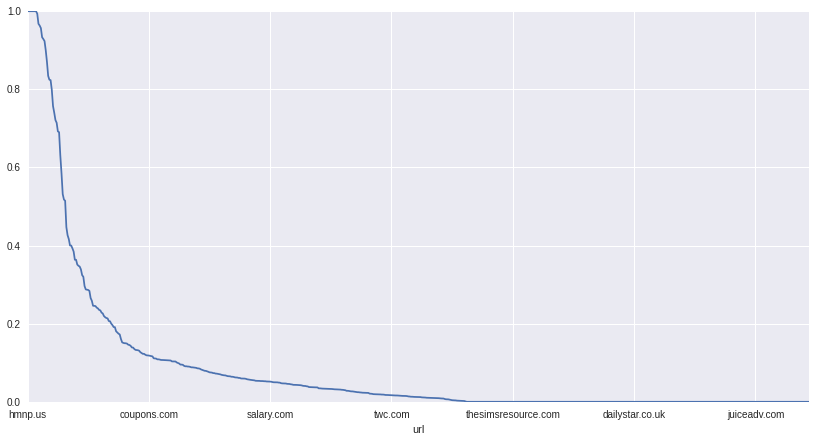

In [20]:
df[df.numreq > 50].sort('bad_share', ascending=False).bad_share.plot()

Hosts ordered by the share of fraudulent users they serve (may be not representative because of limited number of clients in the sample):

In [21]:

url_bad_clients = d[d.ip.isin(bad_clients)].groupby('url').ip.nunique()
url_all_clients = d.groupby('url').ip.nunique()
share = url_bad_clients/url_all_clients
share[share.notnull()].order(ascending=False).plot()

Save web sites into TSV file ordered by the share of suspicious traffic they receive for future examination. We are done.

In [22]:
df[df.numreq > 50].sort('bad_share', ascending=False).to_csv(os.path.join(working_dir, 'fraud_sites.tsv'), sep='\t')

## Conclusion
This method has some drawbacks:
1. K-nearest neighbors methods do not work well in high-dimensional space so the method will degrade in efficiency if we increase the number of topics in the LDA model.
2. It is hard to evaluate its efficiency because of high dimensionality.

Nevertheless, this approach has advantages over methods utilizing PCA and conventional classifiers:
1. It is robust in terms of outliers.
2. It works better as the number of users increases, because LDA model will classify documents more efficiently.
3. No modifications are needed to cope with imbalance in the values of output variable.

PS. A lot of features were generated that were never used in the analysis. I prefer to leave them in the code, because they could be useful in future research.